# Esercitazione 9

L'obiettivo di questa esercitazione è risolvere il problema del commesso viaggiatore (TSP) mediante l'utilizzo di un algoritmo genetico.
La richiesta è di testare l'efficienza dell'algoritmo nel caso di 32 città disposte casualmente su una circonferenza di raggio unitario per poi replicare successivamente quanto fatto nel caso di un insieme di 32 città casualmente disposte all'interno di un quadrato di lato 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Mostra/Nascondi celle</a>.''')

### Esercizio 9.1

Gli algoritmi genetici sono algoritmi di ottimizzazione che sfruttano i meccanismi di adattamento caratteristici del mondo naturale. 
Generalmente un algoritmo genetico cerca la soluzione ottima al problema di interesse simulando l'evoluzione di una popolazione di cromosomi generazione dopo generazione. L'ottimo tra le possibili soluzioni è costituito dal cromosoma caratterizzato dal valore migliore della funzione di costo o *fitness*.
Nel caso di nostro interesse la funzione di costo è la distanza così definita:

$$L(\vec{x}_{1},\vec{x}_{2},...\vec{x}_{N})=\sum_{i=1}^{N-1}\big|\,\vec{x}_{i+1}-\vec{x}_{i}\,\big|$$
 
e cerchiamo il cromosoma che nella popolazione finale minimizza questa quantità. Infatti nel nostro caso un cromosoma rappresenta una possibile soluzione, ossia un percorso tra le posizioni $\vec{x}_i$ che definiscono le città, casualmente generate all'inizio della simulazione. Il percorso deve rispettare alcune limitazioni, ossia:
1. il commesso viaggiatore deve passare da ogni città una e una sola volta;
2. il commesso viaggiatore deve concludere il suo viaggio tornando alla città di partenza.

Se questi due vincoli sono rispettati il cromosoma rappresenta una possibile soluzione al problema. La soluzione ottima è quella con il percorso più breve, o in altre parole quella che possiede la *fitness* più bassa.

L'evoluzione della popolazione procede nel modo seguente.
1. Per prima cosa vengono generati casualmente i cromosomi della popolazione iniziale;
2. I cromosomi vengono poi ordinati in ordine crescente di *fitness*, perciò l'ultimo individuo, conclusa questa operazione, possiede la *fitness* più alta;
3. Vengono poi selezionati 2 cromosomi alla volta, destinati alla riproduzione in base all'algoritmo $j=int(N_{cromosomi}\cdot r^{0.2})$, dove $r\in[0,1)$ è un numero casuale uniforme e $j$ rappresenta l'indice del cromosoma selezionato;
4. Viene effettuato un *cross-over* tra i 2 cromosomi selezionati con probabilità $p_c$. Questa operazione consente agli individui di scambiarsi delle parti di "patrimonio genetico" (ovvero i due cromosomi che si accoppiano influenzano l'uno l'ordine delle città dell'altro). Se ciò non accade, la coppia di individui figli risulta essere (a meno di mutazioni successive) una copia fedele dei genitori;
5. Ciascuno dei due cromosomi figli può subire una o più *mutazioni* diverse che modificano l'ordine con cui il commesso viaggiatore visita le città. La probabilità con cui ciascuna può verificarsi è $p_m$;
6. Vengono ripetuti i punti 3,4,5 per $N_{cromosomi}/2$ volte, sostituendo la popolazione precedente con quella nuova. Viene quindi completata una generazione e si riparte dal punto 2. Il programma termina la simulazione nel momento in cui vengono raggiunte le $N_{generazioni}$ generazioni.

Dal punto di vista computazionale, l'entità elementare che costituisce un singolo gene (ossia una città) è una `struct` la quale contiene informazioni riguardanti la posizione e l'etichetta della città (indice rappresentativo del numero progressivo con cui la città viene generata).
Nella classe `Chromosome`, la successione di città è un `vector` di struct (rappresentazione 1D) inserito come data membro della classe stessa. All'interno di questa classe si possono trovare diversi metodi che hanno come fine quello di modificare la sequenza di geni, un singolo gene o calcolare il valore della *fitness*.
L'algoritmo genetico è implementato nelle sue specificità in una classe a parte che usa un `vector` di cromosomi per rappresentare la popolazione come data membro. Tra i metodi della classe si trovano gli operatori di mutazione così implementati:
* `Mutation1` opera generando una permutazione tra due diverse città;
* `Mutation2` crea una permutazione tra le prime $n$ città contigue e le $N_{città}-n$ città successive;
* `Mutation3` permuta una sequenza di $m$ città contigue partendo dalla posizione $n$ con la sequenza successiva (che parte dalla posizione $m+n$); 
* `Mutation4` inverte l'ordine in cui appaiono nel percorso le città appartenenti ad una sequenza che parte dalla posizione $n>1$ fino alla posizione $m\leq N_{città}$.

L'operatore di *cross-over* viene implementato come suggerito nel testo dell'esercitazione.

A questo punto procediamo con la simulazione.
I parametri che vengono scelti per entrambe le simulazioni richieste sono: $N_{città}=32$, $N_{generazioni}=100$, $N_{cromosomi}=1000$, $p_c= 75\%$, $p_m=5\%$ .
Nei grafici qui sotto vengono mostrati in successione:
* le posizioni delle 32 città con il cammino iniziale non ottimizzato e il miglior percorso trovato dall'algoritmo genetico dopo $N_{generazioni}$;
* l'andamento della *fitness* del miglior cromosoma della popolazione in funzione dello step generazionale e l'evoluzione della *fitness* media della popolazione anch'essa in funzione dello step generazionale.

**A) Percorso lungo una circonferenza**:

Generiamo casualmente le 32 città su una circonferenza di raggio unitario e centrata nell'origine.

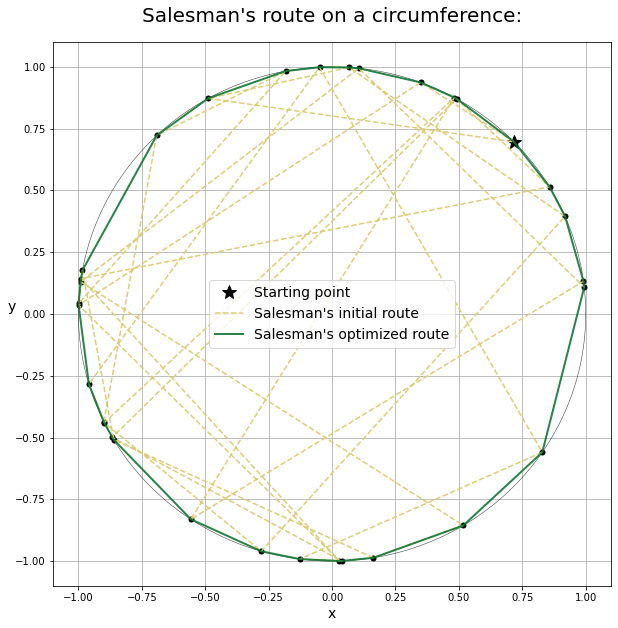

In [16]:
position0 = np.loadtxt('cities_positions.dat')
position00 = np.loadtxt('cities_positions_init.dat')

M=5000                         
np.random.seed(0)     
r = 2*np.pi*np.random.rand(M) 
r.sort()
x_cirle = np.cos(r)
y_cirle = np.sin(r)

plt.figure(figsize=(10,10))
plt.title("Salesman's route on a circumference:", fontsize=20, pad=20)

plt.plot(x_cirle,y_cirle, linestyle ='-', color ='black',alpha=0.8,linewidth=0.5)

#Percorso iniziale:
x0 = position00.T[0]
y0 = position00.T[1]
label = position00.T[2]
for i in range(len(position00)):
    plt.plot(x0[i], y0[i], color='black',marker='.',markersize=10)
    #plt.text(x0[i] * (1 + 0.05), y0[i] * (1 + 0.05) , int(label[i]), fontsize=5)
plt.plot(x0[0],y0[0],'*', markersize=14, label='Starting point',color='black') 
x0 = np.append(x0,x0[0])
y0 = np.append(y0,y0[0])
plt.plot(x0,y0, label= "Salesman's initial route",color='#DDCC77', linestyle='--',alpha =1)

#Percorso finale:
x = position0.T[0]
y = position0.T[1]
x = np.append(x,x[0])
y = np.append(y,y[0])
plt.plot(x,y, label= "Salesman's optimized route",color='#117733', linewidth=2,alpha=0.9)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',rotation=0,fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.grid(True)
plt.show()

Il grafico ci mostra come il commesso viaggiatore compia sicuramente il percorso più breve. Infatti se le città sono disposte lungo la circonferenza, il cammino che minimizza la *fitness* intuitivamente non possiede alcun nodo (incrocio). Questa situazione semplificata ci suggerisce che l'algoritmo funziona correttamente. 

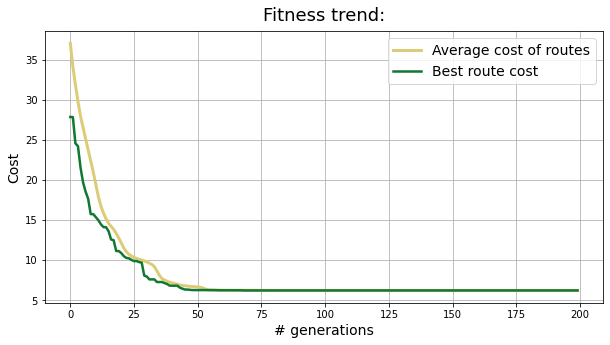

In [4]:
fit = np.loadtxt("best_fit.dat")
mean_fit = np.loadtxt("mean_fit.dat")

plt.figure(figsize=(10,5))
plt.title('Fitness trend:',fontsize=18,pad=10)
plt.plot(mean_fit.T[0],mean_fit.T[1], color='#DDCC77', label="Average cost of routes", alpha=1,linewidth=3)
plt.plot(fit.T[0],fit.T[1], color='#117733', label='Best route cost',linewidth=2.5)
plt.grid(True)
plt.xlabel('# generations',fontsize=14)
plt.ylabel('Cost',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.show()

Questo secondo grafico ci mostra come la *fitness* saturi pochi passi prima della 50esima generazione.
L'evoluzione della *fitness* media invece ci suggerisce che, pochi passi prima della 60esima generazione, ogni cromosoma appartenente alla popolazione è tale da poter risolvere il problema in maniera ottimale.

**B) Percorso all'interno di un quadrato di lato 2**:

Generiamo all'interno di un quadrato di lato 2 (il cui centro è fissato nell'origine del piano) 32 città distribuite casualmente.

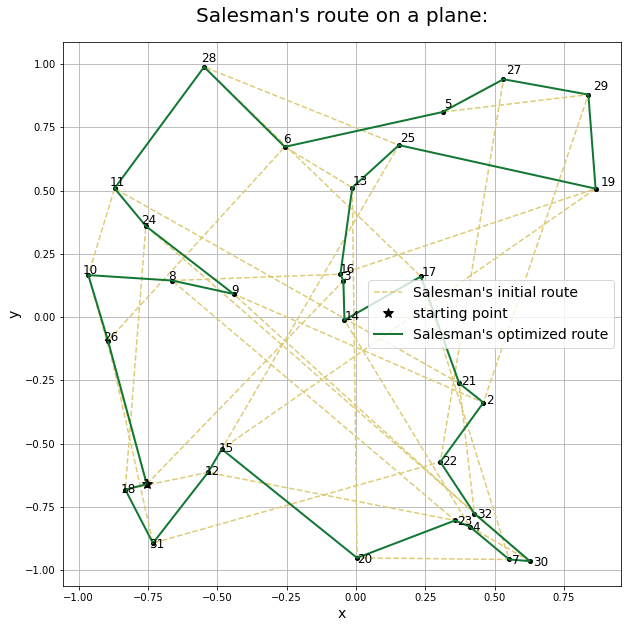

In [20]:
position1 = np.loadtxt('cities_positions1.dat')
position10 = np.loadtxt('cities_positions1_init.dat')

plt.figure(figsize=(10,10))
plt.title("Salesman's route on a plane:", fontsize=20, pad=20)

#Initial route:
x10 = position10.T[0]
y10 = position10.T[1]
x10 = np.append(x10,x10[0])
y10 = np.append(y10,y10[0])
plt.plot(x10,y10,label="Salesman's initial route", color='#DDCC77',linestyle='--')

#Final route:
x1 = position1.T[0]
y1 = position1.T[1]
label = position1.T[2]
for i in range(len(position1)):
    plt.plot(x1[i], y1[i], 'black',marker='.',markersize=8)
    plt.text(x1[i] * (1 + 0.02), y1[i] * (1 + 0.02) , int(label[i]) , fontsize=12)
plt.plot(x1[0],y1[0],'*', markersize=10, color='black',label='starting point') 
x1 = np.append(x1,x1[0])
y1 = np.append(y1,y1[0])
plt.plot(x1,y1,label="Salesman's optimized route", color='#117733',linewidth=2)

plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.grid(True)
plt.show()

A differenza del test su circonferenza, in questo caso non siamo in grado di stabilire se il cammino trovato rappresenta a tutti gli effetti la soluzione ottimale del problema. Tuttavia, coscienti di ciò, possiamo affermare che questa è una soluzione che può essere approssimativamente vicino alla soluzione ottima. Infatti il percorso non è contrassegnato in alcun modo da incroci e perciò rappresenta un risultato soddisfacente per il nostro problema.

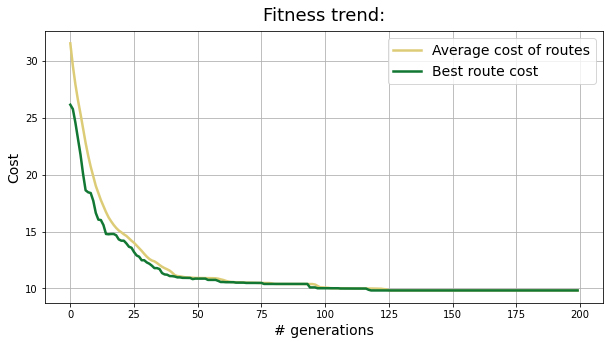

In [11]:
fit1 = np.loadtxt("best_fit1.dat")
mean_fit1 = np.loadtxt("mean_fit1.dat")

#print(fit1[len(fit1)-1][1])

plt.figure(figsize=(10,5))
plt.title('Fitness trend:',fontsize=18,pad=10)
plt.plot(mean_fit1.T[0],mean_fit1.T[1],label='Average cost of routes', alpha=1,linewidth=2.5,color='#DDCC77')
plt.plot(fit1.T[0],fit1.T[1], label='Best route cost',color='#117733',linewidth=2.5)
plt.grid(True)
plt.xlabel('# generations',fontsize=14)
plt.ylabel('Cost',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.show()

A differenza del test su circonferenza, in questo caso la convergenza alla soluzione finale è rallentata. Infatti la *fitness* satura intorno all'120esima generazione al momento della quale raggiunge il valore 9.814. Naturalmente questa difformità può essere dovuta all'incremento della complessità nel trovare a tutti gli effetti il minimo del problema di ottimizzazione.
La media delle *fitness* dei diversi cromosomi converge invece intorno all'125esima generazione.